In [1]:
import nltk

In [2]:
# the following can be of use when identifying tags:
# nltk.help.upenn_tagset()

Let's use the familiar brown corpus to begin with. Get the POS-tagged sentences.

In [3]:
sents = nltk.corpus.brown.tagged_sents()

# Exercise 1 - Introduction to chunking

## 1a)
Make your own noun phrase (NP) chunker, detecting noun phrases and a clause, for which verbs (VB) are followed by a preposition (IN) and/or a noun phrase.

In [4]:
grammar = r'''
NP: {<DT|JJ.*>*?<NN.*>+}
CLAUSE: {<VB.*>+<IN|NP>+}
'''

chunk_parser = nltk.RegexpParser(grammar) 

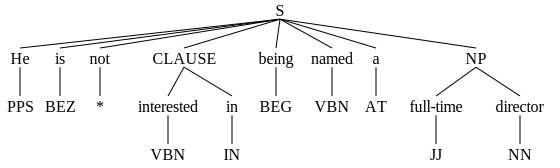

In [5]:
# test your parser!
test_sentence = sents[400][:10]  # just an example sentence, using the first 10 words
chunks = chunk_parser.parse(test_sentence)
chunks

## 1b)
Convert a POS tagged text to a list of tuples, where each tuple consists of a verb followed by a sequence of noun phrases and prepositions.
Example: “the little cat sat on the mat” becomes (‘sat’, ‘on’, ‘NP’) . . . 

In [6]:
def chunks_to_verb_NP_tuples(tagged_sents):
    tuples = set()
    """
    iterate the trees and subtrees of your parser.
    add all chunks starting with a verb (CLAUSE) to the set of tuples
    """
    cp = nltk.RegexpParser(r'''
    NP: {<DT|JJ.*>*?<NN.*>+}
    target: {<VB.*><NP|IN>+}
    ''')

    for sent in tagged_sents:
        tree = cp.parse(sent)
        for subtree in tree.subtrees():
            if subtree.label() == 'target':
                tuples.add((subtree[0][0], subtree[1][0], "NP"))

    return list(tuples)

In [7]:
# check your output :-)
import random

vb_np = chunks_to_verb_NP_tuples(sents)
random.shuffle(vb_np)
vb_np[:20]

[('left', 'next', 'NP'),
 ('shifting', ('styles', 'NNS-HL'), 'NP'),
 ('hold', 'to', 'NP'),
 ('broadens', ('shadows', 'NNS'), 'NP'),
 ('checked', 'by', 'NP'),
 ('showed', ('small', 'JJ'), 'NP'),
 ('working', ('days', 'NNS'), 'NP'),
 ('buried', 'under', 'NP'),
 ('commencing', 'with', 'NP'),
 ('allowed', ('parent', 'NN-HL'), 'NP'),
 ('Listen', 'to', 'NP'),
 ('got', ('that', 'DT'), 'NP'),
 ('flailed', 'at', 'NP'),
 ('picked', 'Cathy', 'NP'),
 ('snows', ('peas', 'NNS'), 'NP'),
 ('buttressed', 'by', 'NP'),
 ('spiral', 'into', 'NP'),
 ('achieve', ('goals', 'NNS'), 'NP'),
 ('rising', ('tide', 'NN'), 'NP'),
 ('allow', ('vent', 'NN'), 'NP')]

## 1c)
Using the pre-annotated test set from wall street journal data (conll2000 in nltk), experiment with different grammars to get the highest possible F-measure. There is no evaluation of this task, but rather a motivator to learn something about grammars.

In [8]:
wsj = nltk.corpus.conll2000
test_sents = wsj.chunked_sents('test.txt', chunk_types=['NP'])
# {<DT>?<JJ.*>?<NN.*>+}
# (\w+ DT)? (\w+ JJ)*|(\w+ (?:NN|NP|PRN)

chunk_parser = nltk.RegexpParser(r'''
NP: {<DT>?<JJ.*>?<NN.*>+}
''') #TODO: your parser
print(chunk_parser.accuracy(test_sents))

ChunkParse score:
    IOB Accuracy:  79.9%%
    Precision:     70.3%%
    Recall:        61.0%%
    F-Measure:     65.3%%


# Exercise 2 - Making use of chunks

## 2a)
With the following grammar rules:
```
1. proper noun singular
2. determiner followed by an adjective, followed by any noun
3. two consecutive nouns
```
Create a `RegexpParser` chunker

In [9]:
grammar = r'''
1: {<NNP>}
2: {<DT><JJ><NN.*>}
3: {<NN.*><NN.*>}
'''
# TODO: set up a parser using the grammar you defined
chunk_parser = nltk.RegexpParser(grammar)

def chunker(sent):
    return chunk_parser.parse(sent)

## 2b)

Read the file `starlink.txt` and perform the following operations on the text:
- sentence tokenize
- word tokenize
- pos tag

In [10]:
import os

"""
TODO:
- read the file "starlink.txt"
- tokenize and tag the words of each sentence

the below function is just an idea of generalization to any file.
you can delete this and write your own code.
"""
def get_pos_tags_from_file(filename):
    cwd = os.getcwd()
    data_dir = os.path.join(cwd, "data")
    with open(os.path.join(data_dir, filename), "r") as f:
        working_file = f.read()
    sents = nltk.sent_tokenize(working_file)
    words = [nltk.word_tokenize(sent) for sent in sents]
    pos_words = nltk.pos_tag_sents(words)
    
    return pos_words
    
starlink_tagged = get_pos_tags_from_file("starlink.txt")

## 2c)
From all found subtrees in the text, print out the text from all the leaves on the form of `DT -> JJ -> NN` (i.e. the CONSECUTIVE chunk you defined above)

In [11]:
"""
TODO:
write a function to retrieve the DT-JJ-NN sequences
from the grammar you defined in 2a)
"""
def get_descriptive_nouns(tagged_sents):
    descriptive_nouns = []

    for sent in tagged_sents:
        for subtree in chunker(sent).subtrees():
            if subtree.label() == "2":
                text = (" ".join([w for w, POS in subtree.leaves()]))
                descriptive_nouns.append(text)
    return descriptive_nouns


get_descriptive_nouns(starlink_tagged)

['a one-day delay',
 'a successful deployment',
 'the other launches',
 'a classified payload',
 'the first launch',
 'a solar storm',
 'a different approach',
 'The previous launch',
 'a single burn',
 'the upper stage',
 'a second burn',
 'the atmospheric drag',
 'the previous set']

## 2d)
Create a custom rule for a combination of 3 or more tags, similarly to task c).

Do you see any practical uses for chunking with this rule, or in general?

# Exercise 3 - Context-free grammar (CFG)

## 3a)
Create a cfg to handle sentences such as "she is programming", "they are coding" (look at the word forms and POS). The first verb should only handle present tense, while the second verb is flexible. Note that you need to specify the accepted words.

In [ ]:
cfg = nltk.CFG.fromstring("""
TODO
""")
cfg.productions()

#### A little function to visualize some possible outputs of the grammar
#### Do not change this

In [ ]:
def generate_sample(grammar, start, tokens):        
    # iterate left hand and right hand side of the tree
    if start in grammar._lhs_index:
        derivation = random.choice(grammar._lhs_index[start])            
        for rhs in derivation._rhs:          
            generate_sample(grammar, rhs, tokens)
    elif start in grammar._rhs_index:
        tokens.append(str(start))
    return tokens

for _ in range(10):
    print(generate_sample(cfg, cfg.start(), []))

## 3b)
Find some problems with the above CFG, any ideas how you would improve the results?

## 3c)
Initialize a `ChartParser` with the cfg from 3a).

Write a function to retrieve words not defined by your grammar.

In [ ]:
cfg_parser = None # TODO chartparser of cfg grammar above

"""
TODO
write a function that returns a list of missing tokens (not covered by your cfg)
Look up "lexical index" of a grammar.
"""

Finish the below function

In [ ]:
def parse(parser, cfg_grammar, sent):
    tokens = None # TODO word tokens
    missing = get_missing_words(cfg_grammar, tokens)
    if missing:
        print("Grammar does not cover: {}".format(missing))
        return
    trees = None # TODO: a list of parsed tokens
    for tree in trees:
        print(tree)
    if len(trees) > 0:
        return trees[0]
    else:
        print("Ungrammatical sentence.")

## 3d)
output the tree of your parser for the sentence "they are programming"

In [ ]:
txt = "they are programming"
parse(cfg_parser, cfg, txt)

# Exercise 4 - Tweet like Trump! Now that he's banned
Using the provided file "realDonaldTrump.json", you will build a language model to generate Trump-esque tweets using n-grams.

Hint: make use of "padded_everygram_pipeline" supported in nltk.lm. This creates all ngrams up to the specified N-parameter with padding:

Example:
```
('<s>',)
('<s>', '<s>')
('<s>', '<s>', '<s>')
('<s>', '<s>', '<s>', '<s>')
('<s>', '<s>', '<s>', '<s>', 'i')
('<s>',)
('<s>', '<s>')
('<s>', '<s>', '<s>')
('<s>', '<s>', '<s>', 'i')
('<s>', '<s>', '<s>', 'i', 'am')
('<s>',)
('<s>', '<s>')
('<s>', '<s>', 'i')
('<s>', '<s>', 'i', 'am')
('<s>', '<s>', 'i', 'am', 'asking')
('<s>',)
('<s>', 'i')
('<s>', 'i', 'am')
('<s>', 'i', 'am', 'asking')
('<s>', 'i', 'am', 'asking', 'for')
('i',)
('i', 'am')
('i', 'am', 'asking')
('i', 'am', 'asking', 'for')
('i', 'am', 'asking', 'for', 'everyone')
```

In [ ]:
import json
import pickle
import os
# TODO imports for nltk n-gram modeling and LM

Load the JSON data and store the texts:

In [ ]:
with open("data/realDonaldTrump.json") as fp:
    tweets = json.load(fp)

texts = list(map(lambda x: x.get("text"), tweets))

In [ ]:
# let's use this path to store our model after training, so it's easier to reuse later :)
pickle_path = "model.pkl"

Finish the `train_model` function.

In [ ]:
def train_model(data):
    tokenized = None  # TODO: use a tokenizer for the twitter data
    n = 0 # TODO find an appropriate N-gram 
    train_data, padded_vocab = None # TODO: padded everygram
    # 
    model = None # TODO: from nltk.lm (language model), use an appropriate estimator
    model.fit(train_data, padded_vocab)
    # save the model if you want to :-) then we can load it in the next step without retraining!
    with open(pickle_path, "wb") as fp:
        pickle.dump(model, fp)
    return model

In [ ]:
if os.path.exists(pickle_path):
    with open(pickle_path, "rb") as fp:
        model = pickle.load(fp)
else:
    model = train_model(texts)

In [ ]:
def generate_sentence(model, txt):
    txt = None  # TODO: tokenize the input
    while True:
        next_word = model.generate(text_seed=txt, random_seed=42)
        if next_word == '</s>':
            break
        txt.append(next_word)
        
    def filter_fn(txt):
        no_http = "http" not in txt
        some_other_rule = True
        
        return no_http or some_other_rule
    
    return " ".join([t for t in txt if filter_fn(t)])

In [ ]:
generate_sentence(model, "some sentence")

## 4b)
Create a grammar to chunk some typical trump statements.

There are multiple approaches to this. One way would be to use your own input to the model and look at the resulting outputs and their POS tags. Another possible approach is to use the training data to group together e.g. 5-grams of POS tags to look at the most frequently occurring POS tag groupings. The aim is to have a chunker that groups utterances like "so sad", "make america great again!" and so forth.

Show your results using the outputs from your model with these inputs: 
- "clinton will"
- "obama is"
- "build a"
- "so sad"

In [ ]:
trump_grammar = r"""
TODO
"""
